In [39]:
query = 'RAG'

In [40]:
import os, sys, nltk
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import ipywidgets as widgets
from Preprocess import load_df, load_pickle, load_pickle_files,prep_query
from Searching_Method.Neural_Reranking import retrieve_and_rerank
from Searching_Method.BM25andDenseEmbeddings import load_split_embeddings, combined_ranking, bm25_search, clickable
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import matplotlib.pyplot as plt
from rank_bm25 import BM25Okapi
from IPython.display import display, clear_output

# preprocess
if os.path.exists('./bm25-vector-search/data/'):
    path = './bm25-vector-search/data/'
elif os.path.exists('./data/'):
    path = './data/'
else:
    print('Error: Could not find data directory')
    print('Please run from either root or bm25-vector-search directory')
    exit(1)

print('Loading DataFrame...')
df = load_df(path + 'arxiv_csAI_subset.json.gz')

print('Loading Pickle Files...')
titles_file = path + 'titles_inverted_indices.pkl.gz'
abstracts_file = path + 'abstracts_inverted_indices.pkl.gz'
title_term_table = load_pickle(titles_file)
abstract_term_table = load_pickle(abstracts_file)

titles_file = path + 'titles_lengths.pkl.gz'
abstracts_file = path + 'abstracts_lengths.pkl.gz'
title_lengths = load_pickle(titles_file)
abstract_lengths = load_pickle(abstracts_file)

nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

stemmer = SnowballStemmer('english')
# BM25 Configuration Variables
N = len(title_lengths)
avg_doc_len_title = sum(title_lengths.values()) / N
avg_doc_len_abs = sum(abstract_lengths.values()) / N
# Load the split embedding files
document_embeddings = load_split_embeddings(path)
model = SentenceTransformer('all-MiniLM-L6-v2')
query = prep_query(query, stop_words, stemmer)

Loading DataFrame...
Loading Pickle Files...


## Level 1_TF-IDF

In [41]:
import pandas as pd
import re
"""#Global TF-IDF feature for the whole dataset"""

def plot_top_tfidf_features(vectorizer, matrix, top_n=20):
    """
    Plots the top N terms by their average TF-IDF score across all documents.
    This helps visualize which terms are most significant in the dataset.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # Calculate average TF-IDF score for each term
    # mean(axis=0) returns a matrix, so we flatten it to a 1D array
    avg_scores = np.array(matrix.mean(axis=0)).flatten()

    # Get feature names from the vectorizer
    feature_names = vectorizer.get_feature_names_out()

    # Create a DataFrame
    features_df = pd.DataFrame({
        'term': feature_names,
        'score': avg_scores
    })

    # Sort and take top N
    top_features = features_df.sort_values(by='score', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(top_features['term'], top_features['score'], color='#2c3e50')
    plt.xlabel('Average TF-IDF Score')
    plt.ylabel('Term')
    plt.title(f'Top {top_n} Most Important Terms by TF-IDF Score')
    plt.gca().invert_yaxis()  # Highest score at the top
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
def plot_relevance_bars(results, query):
    plt.figure(figsize=(10, 5))
    titles = [t[:50] + '...' if len(t) > 50 else t for t in results['title']]
    scores = results['relevance_score'].values

    plt.barh(range(len(titles)), scores, color=plt.cm.viridis(np.linspace(0.3, 0.9, len(titles))))
    plt.yticks(range(len(titles)), titles)
    plt.xlabel('Relevance Score')
    plt.title(f'Top Results for: "{query}"')
    plt.gca().invert_yaxis() # Best result at top
    plt.tight_layout()
    plt.show()

def plot_wordcloud(results):
    text = ' '.join(results['combined_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Common Terms in Search Results')
    plt.tight_layout()
    plt.show()


In [42]:

df['cleaned_text'] = df['title'] + " " + df['abstract']

tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.8
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])
print(f"TF-IDF Matrix Built: {tfidf_matrix.shape}")

TF-IDF Matrix Built: (150867, 5000)


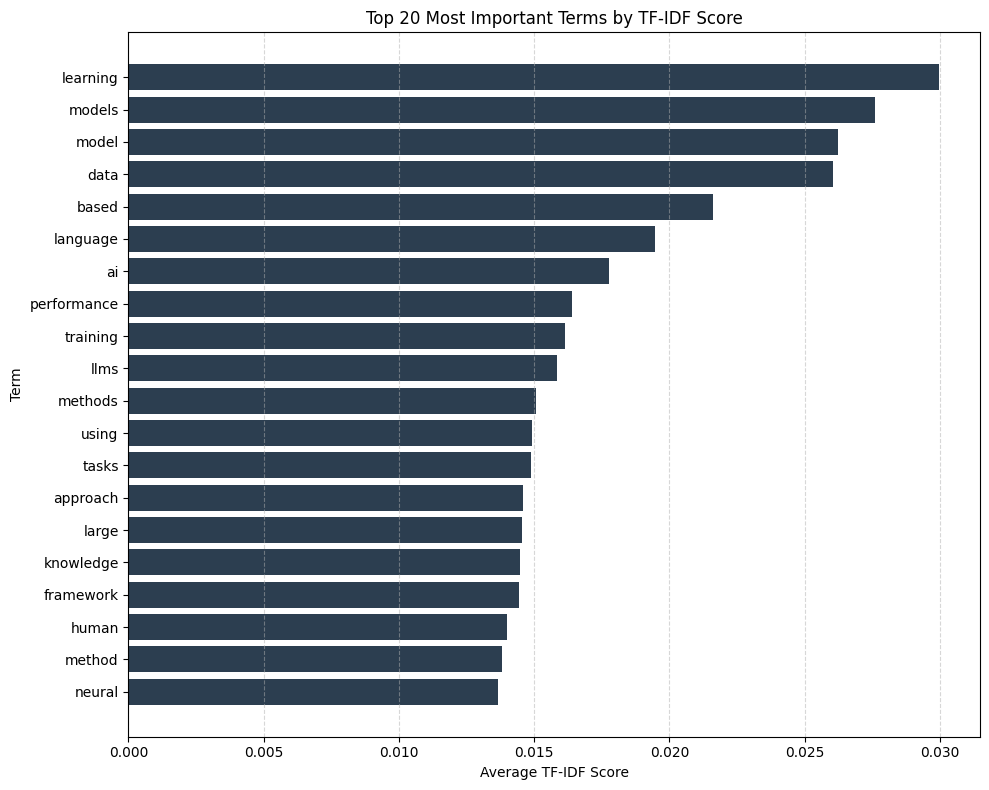

In [43]:
# Call the function (assuming tfidf_vectorizer and tfidf_matrix exist from Part 2)
plot_top_tfidf_features(tfidf_vectorizer, tfidf_matrix)

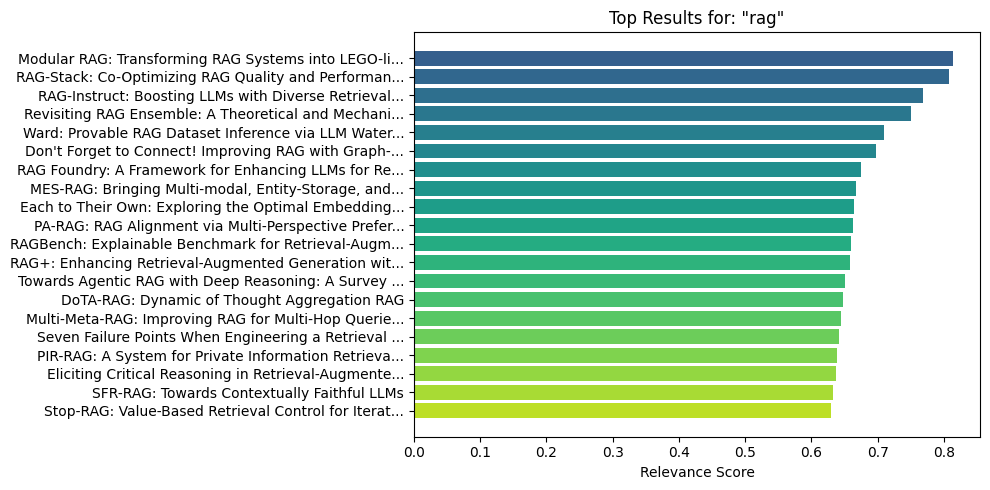

In [44]:
from Searching_Method.TFIDF import TFIDF
import matplotlib.pyplot as plt

TFIDF = TFIDF(df)  
results, _ = TFIDF.search_papers(query, top_n=20)
plot_relevance_bars(results, query)

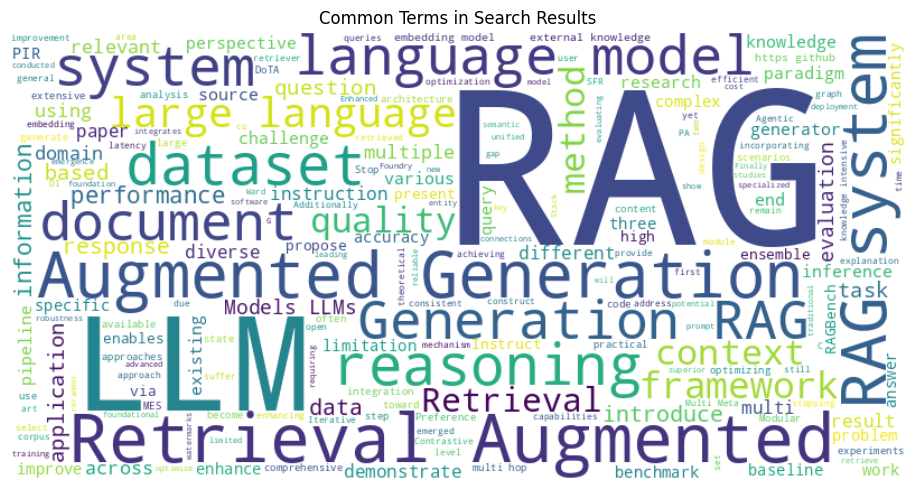

In [45]:
from wordcloud import WordCloud
plot_wordcloud(results)

Scanning full dataset to compare trends. This may take 1-2 minutes...


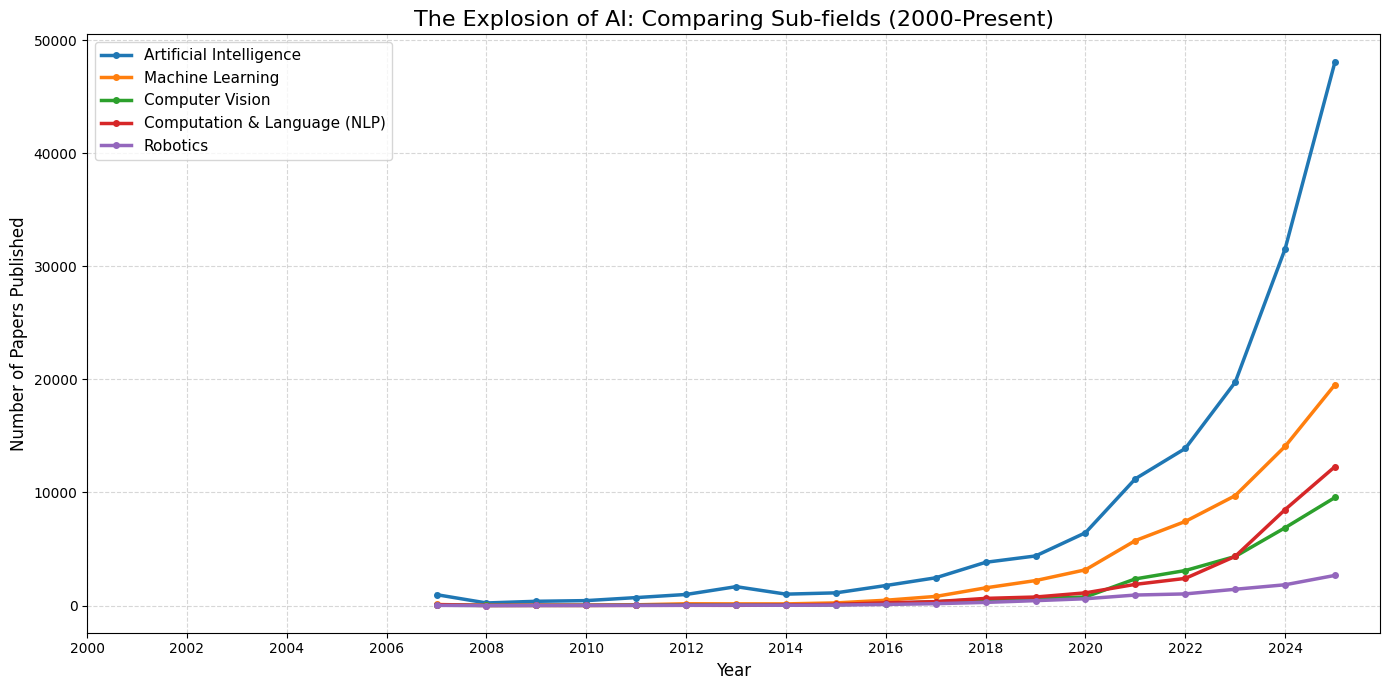

In [46]:
import matplotlib.pyplot as plt
import json
import gzip  # <--- IMPORT THIS

# Define the categories we want to compare
categories_to_track = ['cs.AI', 'cs.LG', 'cs.CV', 'cs.CL', 'cs.RO']
category_labels = {
    'cs.AI': 'Artificial Intelligence',
    'cs.LG': 'Machine Learning',
    'cs.CV': 'Computer Vision',
    'cs.CL': 'Computation & Language (NLP)',
    'cs.RO': 'Robotics'
}

# Initialize counters
counts = {cat: {} for cat in categories_to_track}

print("Scanning full dataset to compare trends. This may take 1-2 minutes...")

# FIX: Use gzip.open with 'rt' (read text) mode
with gzip.open(path + 'arxiv_csAI_subset.json.gz', 'rt') as f:
    for line in f:
        try:
            doc = json.loads(line)
            year = int(doc['update_date'][:4])

            # We only care about recent history (e.g., post-2000)
            if year < 2000: continue

            # Check if paper belongs to any of our target categories
            paper_categories = doc.get('categories', '').split()
            for cat in categories_to_track:
                if cat in paper_categories:
                    counts[cat][year] = counts[cat].get(year, 0) + 1
        except:
            continue

# Plot the comparison
plt.figure(figsize=(14, 7))

# Helper to avoid crashing if 'years' is empty
max_year = 2000 

for cat in categories_to_track:
    if not counts[cat]: continue # Skip if empty
    
    years = sorted(counts[cat].keys())
    if years:
        max_year = max(max_year, max(years))
        
    paper_counts = [counts[cat][y] for y in years]
    plt.plot(years, paper_counts, marker='o', markersize=4, label=category_labels[cat], linewidth=2.5)

plt.title('The Explosion of AI: Comparing Sub-fields (2000-Present)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Papers Published', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(2000, max_year + 1, 2)) 
plt.tight_layout()
plt.show()

In [47]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def __init__(self, df):
        """
        Initializes the TFIDF object by preparing text and author data and computing the TF-IDF matrix.
        """
        self.df = df
        
        # FIX: Fill NaN values with empty strings before concatenating
        self.df['combined_text'] = df['title'].fillna('') + " " + df['abstract'].fillna('')

        def parse_authors(auth_str):
            if not isinstance(auth_str, str): return []
            return [a.strip() for a in auth_str.replace(' and ', ', ').split(',') if a.strip()]

        self.df['author_list'] = df['authors'].apply(parse_authors)

        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=5000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.8
        )
        self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(self.df['combined_text'])


def plot_community_network(G, communities_detected, community_names_map, filename='community_bridge_network.png'):
    node_community_map = {}
    for i, comm in enumerate(communities_detected):
        for node in comm:
            node_community_map[node] = i

    bridge_nodes = []
    for node in G.nodes():
        my_comm = node_community_map.get(node)
        neighbors = list(G.neighbors(node))
        if not neighbors: continue
        foreign_neighbors = sum(1 for v in neighbors if node_community_map.get(v) != my_comm)
        if foreign_neighbors > 0:
            bridge_nodes.append(node)

    # Prepare node colors and sizes
    node_colors = []
    node_sizes = []
    for node in G.nodes():
        comm_id = node_community_map.get(node)
        is_bridge = node in bridge_nodes
        node_colors.append(comm_id)  # Use community id for color mapping
        node_sizes.append(300 if is_bridge else 100)  # Larger size for bridge nodes

    # Create color map for communities
    unique_communities = set(node_community_map.values())
    color_map = plt.cm.get_cmap('tab10', len(unique_communities))

    # Draw the network
    pos = nx.spring_layout(G, seed=42)  # For consistent layout
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=node_sizes, 
            cmap=color_map, edge_color='gray', alpha=0.7, font_size=8)
    
    # Add legend for communities
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(i), 
                          markersize=10, label=community_names_map.get(i, f'Community {i}')) 
               for i in unique_communities]
    plt.legend(handles=handles, title="Communities", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.title("Community Network with Bridge Nodes")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


/tmp/ipykernel_100921/4151758071.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_communities))
/tmp/ipykernel_100921/4151758071.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


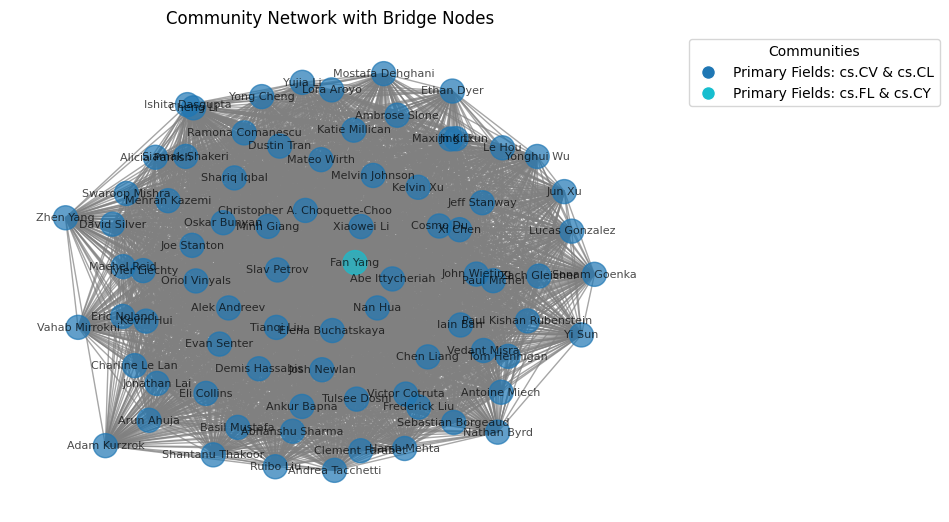

In [48]:
author_subgraph = TFIDF.build_author_network(min_edge_weight=2, top_nodes_count=80)
communities = TFIDF.detect_communities(author_subgraph)
community_names = TFIDF.generate_community_names(communities)
plot_community_network(author_subgraph, communities, community_names)

In [49]:
def explain_search_match(query, doc_text, vectorizer):
    """
    Visualizes WHY a specific document matched the query.
    Takes 3 arguments: query (str), doc_text (str), vectorizer (TfidfVectorizer).
    """
    
    # 1. Vectorize the Query and the Document
    query_vec = vectorizer.transform([query])
    doc_vec = vectorizer.transform([doc_text])

    # 2. Calculate the Element-wise Product (The "Overlap")
    contribution = query_vec.multiply(doc_vec).toarray().flatten()

    # 3. Find indices where contribution > 0
    relevant_indices = contribution.nonzero()[0]

    if len(relevant_indices) == 0:
        print("No exact term overlap found.")
        return

    # 4. Map indices to words and scores
    # NOTE: We get feature_names directly from the vectorizer here
    try:
        feature_names = vectorizer.get_feature_names_out()
    except AttributeError:
        # Fallback for older sklearn versions
        feature_names = vectorizer.get_feature_names()
        
    words = [feature_names[i] for i in relevant_indices]
    scores = [contribution[i] for i in relevant_indices]

    # 5. Create DataFrame and Sort
    explanation_df = pd.DataFrame({'term': words, 'contribution': scores})
    explanation_df = explanation_df.sort_values(by='contribution', ascending=True)

    # 6. Plot
    plt.figure(figsize=(10, 4))
    plt.barh(explanation_df['term'], explanation_df['contribution'], color='#e74c3c')
    plt.xlabel('Contribution to Relevance Score')
    plt.title(f'Why is this the top result? (Term Contributions)')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [50]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic characters
    text = ' '.join(text.split()) # Remove extra whitespace
    return text

def search_papers(query, top_n=10):
    """
    Searches for papers using the global TF-IDF model.
    """
    cleaned_query = clean_text(query)
    query_vec = tfidf_vectorizer.transform([cleaned_query])

    # Calculate similarity
    cosine_scores = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Get top N results
    top_indices = cosine_scores.argsort()[-top_n:][::-1]

    # Retrieve results
    results = df.iloc[top_indices].copy()
    results['relevance_score'] = cosine_scores[top_indices]

    # Ensure combined_text is present
    if 'combined_text' not in results.columns:
        results['combined_text'] = results['title'] + " " + results['abstract']

    # Return relevant columns
    return results[['id', 'title', 'authors', 'update_date', 'relevance_score', 'combined_text']], cosine_scores


In [ ]:
# Widgets
query_input = widgets.Text(
    value='',
    placeholder='Enter keywords (e.g., "neural networks")',
    description='Query:',
    style={'description_width': 'initial'}
)

results_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=20,
    description='Max Results:',
    style={'description_width': 'initial'}
)

search_button = widgets.Button(description="Search")
output_area = widgets.Output()

def on_search_clicked(b):
    with output_area:
        clear_output()
        query = query_input.value
        if not query:
            print("Please enter a search query.")
            return

        print(f"Searching for '{query}'...")
        results, _ = search_papers(query, top_n=results_slider.value)

        if results.empty or results['relevance_score'].max() == 0:
            print("No relevant papers found.")
        else:
            # Display Table
            display(results[['title', 'authors', 'update_date', 'relevance_score']])

            ##new code her 11/25##########################################
            top_paper_text = results.iloc[0]['combined_text']
            explain_search_match(query, top_paper_text, tfidf_vectorizer)



search_button.on_click(on_search_clicked)

 # Display UI
ui = widgets.VBox([
    widgets.HBox([query_input, results_slider, search_button]),
    output_area
 ])
display(ui)

print("\n--- Research Paper Search Engine ---")


--- Research Paper Search Engine ---


## Level 2_Hybrid

In [52]:
titles = list(df['title'].str.lower().str.replace('-', ' ', regex=False).str.replace(r'\s+', ' ', regex=True).str.strip().str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\n', '', regex=True).str.replace(r'  ', ' ', regex=True))
abstracts = list(df['abstract'].str.lower().str.replace('-', ' ', regex=False).str.replace(r'\s+', ' ', regex=True).str.strip().str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\n', '', regex=True).str.replace(r'  ', ' ', regex=True))
tokenize_titles = [t.split(' ') for t in titles]
tokenize_abstracts = [a.split(' ') for a in abstracts]
titles_bm25 = BM25Okapi(tokenize_titles)
abstracts_bm25 = BM25Okapi(tokenize_abstracts)

In [53]:
query = 'Dynamic Retrieval for Improving Generation Quality in RAG Models'
res_df = bm25_search(query,titles_bm25, abstracts_bm25)
search_res = clickable(df.iloc[res_df])
display(HTML('<br>'.join(search_res)))

In [54]:
google_scholar = [
    'Rag and rau',
    'Raft: Adapting language',
    'Learning to adapt retrieval-augmented',
    'C-rag: Certified generation'
    ]

idxs = []
for t in google_scholar:
  res = df[df['title'].str.contains(t, case=False)]
  if res.size > 0:
    idxs.append(int(res.index[0]))
word = 'neural'
word_count = []
counts_dict = {}
for i, abstract in enumerate(abstracts):
  count = abstract.count(word)
  if count not in counts_dict:
    counts_dict[count] = 0
  if counts_dict[count] < 5:
    word_count.append((i, count))
    counts_dict[count] += 1

word_count = sorted(word_count, key=lambda a: a[1])
word_count = word_count[4:]
all_scores_papers_idx = bm25_search("rag models", titles_bm25, abstracts_bm25, top_k='all')
all_scores = df.iloc[all_scores_papers_idx]
google_scores = [(i, s[0], s[1]) for i, s in enumerate(all_scores) if s[1] in idxs]


In [55]:
papers_to_score = [w[0] for w in word_count]
abstracts_to_score = [tokenize_abstracts[i] for i in papers_to_score]

scores = abstracts_bm25.get_scores([word])

bm25_scores = [scores[i] for i in papers_to_score]

lengths = [len(a) for a in abstracts_to_score]
bm25_counts = [w[1] for w in word_count]

abstracts_texts = [" ".join(a) for a in tokenize_abstracts]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(abstracts_texts)

word_idx = vectorizer.vocabulary_.get(word)


tfidf_scores_all = X[:, word_idx].toarray().flatten()

tfidf_scores = [tfidf_scores_all[i] for i in papers_to_score]

tfidf_counts = [w[1] for w in word_count]
bm25_norm = (bm25_scores - np.min(bm25_scores)) / (np.max(bm25_scores) - np.min(bm25_scores))
tfidf_norm = (tfidf_scores - np.min(tfidf_scores)) / (np.max(tfidf_scores) - np.min(tfidf_scores))

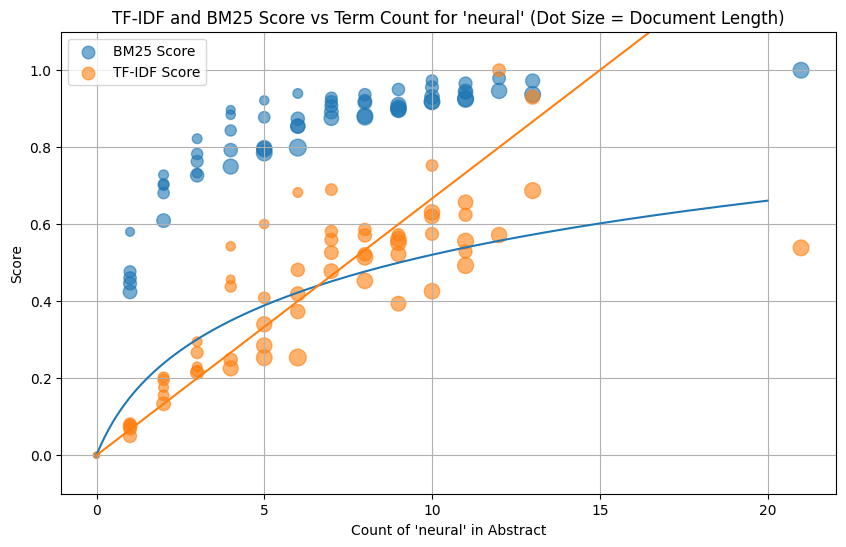

In [56]:
plt.figure(figsize=(10, 6))

sizes = [l / 2 for l in lengths]

# Compare BM25 and Log Curve
plt.scatter(bm25_counts, bm25_norm, s=sizes, alpha=0.6, label="BM25 Score")
x = np.linspace(0, 20, 500)
y1 = np.log10(x + 1) / 2
plt.plot(x, y1)

y2 = x/15
plt.plot(x, y2)
plt.scatter(tfidf_counts, tfidf_norm, s=sizes, alpha=0.6, label="TF-IDF Score")

plt.xlabel(f"Count of '{word}' in Abstract")
plt.ylabel("Score")
plt.title(f"TF-IDF and BM25 Score vs Term Count for '{word}' (Dot Size = Document Length)")
plt.grid(True)
plt.legend()
plt.ylim(-0.1, 1.1)

plt.show()

### The plot shows that TF-IDF increases almost linearly with term frequency, while BM25 saturates and avoids over-rewarding repetition. This indicates that frequency alone does not imply relevance, and BM25 offers a more balanced and context-aware signal—making it better suited for RAG retrieval.

In [57]:
query_embedding = model.encode([query])
similarities = cosine_similarity(query_embedding, document_embeddings)[0]
worst_indices = np.argsort(similarities)[:3]
best_indices = np.argsort(similarities)[::-1][:3]
embeddings = np.concatenate([query_embedding, document_embeddings[best_indices], document_embeddings[worst_indices]], axis=0)

In [58]:
pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=2, perplexity=5, max_iter=300)
reduced_tsne = tsne.fit_transform(embeddings)

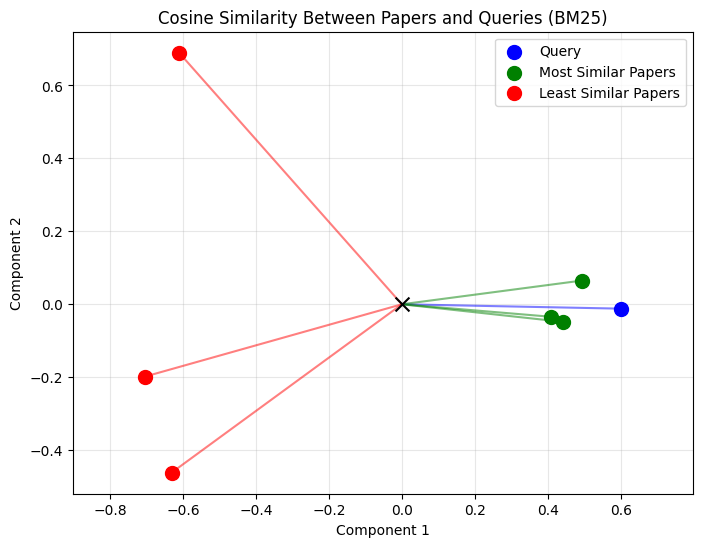

In [59]:
plt.figure(figsize=(8, 6))

colors = ['blue', 'green', 'red']
labels = ['Query', 'Most Similar Papers', 'Least Similar Papers']
groups = [slice(0, 1), slice(1, 4), slice(4, None)]

for color, label, group in zip(colors, labels, groups):
  points = reduced_pca[group]

  for point in points:
    plt.plot([0, point[0]], [0, point[1]],
              color=color, alpha=0.5, linewidth=1.5)

  plt.scatter(points[:, 0], points[:, 1],
              color=color, label=label, s=100, zorder=5)

plt.scatter(0, 0, color='black', s=100, marker='x', zorder=10)

plt.title('Cosine Similarity Between Papers and Queries (BM25)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

### Relevant papers cluster near the query, while irrelevant ones diverge sharply—showing BM25 clearly distinguishes meaningful matches.

## Level 3_Reranking

In [60]:
#  Neural Reranking with Cross-Encoders
print("Using Cross-Encoder to rerank top 100 files")
candidates = combined_ranking(query, 100, title_term_table, abstract_term_table, title_lengths, abstract_lengths, avg_doc_len_title, avg_doc_len_abs, N, model, document_embeddings)

candidates_with_text = []
# put in the text to rerank 
for doc_id, score in candidates:
    abstract = df.iloc[doc_id].get("abstract", "")
    title    = df.iloc[doc_id].get("title", "")
    text     = title + " " + abstract            
    candidates_with_text.append((doc_id, text))

reranked = retrieve_and_rerank(
    query,
    candidates_with_text,
    final_k=100
)

Using Cross-Encoder to rerank top 100 files


In [61]:
import pandas as pd
import matplotlib.pyplot as plt
# write the results from level2 and level 3 into dataframe
original_ranks = {doc_id: rank for rank, (doc_id, _) in enumerate(candidates, start=1)}

rows = []
for rank_after, (score_after, doc_id) in enumerate(reranked, start=1):
    row = df.iloc[doc_id]
    rows.append({
        "doc_id": doc_id,
        "score_after": score_after,
        "rank_after": rank_after,
        "rank_before": original_ranks.get(doc_id, None),
        "title": row.get("title", ""),
        "update_date": row.get("update_date", None),
        "arxiv_id": row.get("id", None),
    })

results_df = pd.DataFrame(rows)

if results_df["update_date"].dtype == "object":
    results_df["update_date"] = pd.to_datetime(results_df["update_date"], errors="coerce")

results_df.head()


,doc_id,score_after,rank_after,rank_before,title,update_date,arxiv_id
0,140942,7.418201,1,77,Enhancing Retrieval Augmentation via Adversari...,2025-09-19,2509.14750
1,118110,7.217091,2,45,A Survey on Knowledge-Oriented Retrieval-Augme...,2025-03-18,2503.10677
2,124989,6.773302,3,57,Accelerating Adaptive Retrieval Augmented Gene...,2025-05-27,2505.12731
3,115307,6.628273,4,52,On the Influence of Context Size and Model Cho...,2025-02-21,2502.14759
4,111260,6.607348,5,23,Enhancing Retrieval-Augmented Generation: A St...,2025-01-14,2501.07391


### The cross-encoder reranker noticeably reshapes the ranking results by promoting papers that were originally much lower in the candidate list but more semantically relevant to the query. This shows that neural reranking provides finer-grained relevance judgment than BM25 and dense embeddings alone.

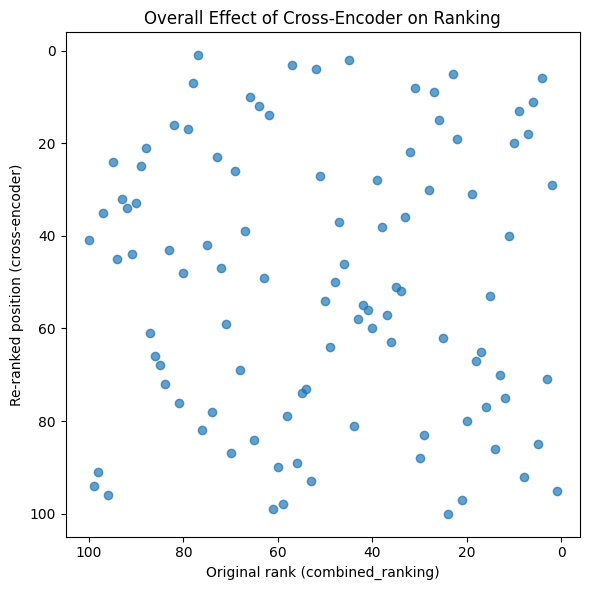

In [62]:
# ranking vs reranked

valid_df = results_df.dropna(subset=["rank_before"])

plt.figure(figsize=(6, 6))
plt.scatter(valid_df["rank_before"], valid_df["rank_after"], alpha=0.7)
plt.xlabel("Original rank (combined_ranking)")
plt.ylabel("Re-ranked position (cross-encoder)")
plt.title("Overall Effect of Cross-Encoder on Ranking")


plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


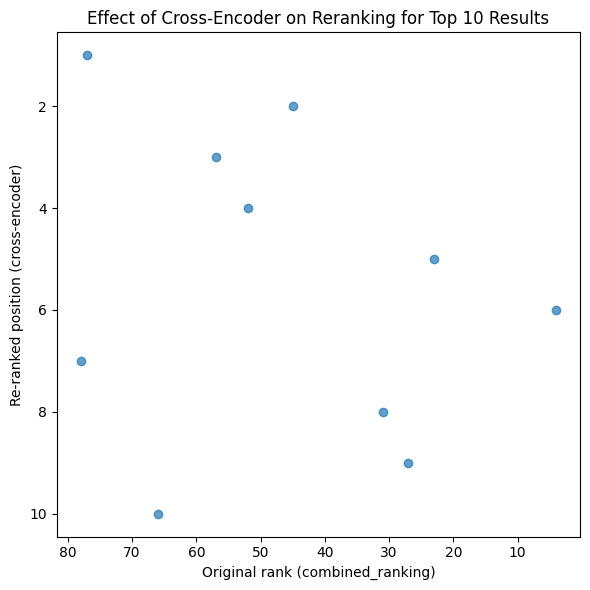

In [63]:
# ranking vs reranked top 10

choose_top_n = 10   # change to view top n results

plt.figure(figsize=(6, 6))
plt.scatter(results_df["rank_before"][:choose_top_n], results_df["rank_after"][:choose_top_n], alpha=0.7)
plt.xlabel("Original rank (combined_ranking)")
plt.ylabel("Re-ranked position (cross-encoder)")
plt.title("Effect of Cross-Encoder on Reranking for Top 10 Results")


plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


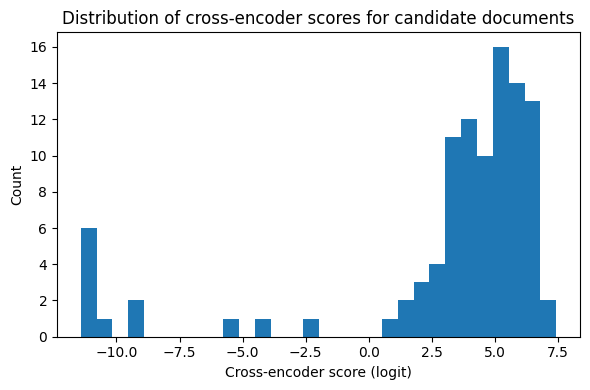

In [64]:
plt.figure(figsize=(6, 4))
plt.hist(results_df["score_after"], bins=30)
plt.xlabel("Cross-encoder score (logit)")
plt.ylabel("Count")
plt.title("Distribution of cross-encoder scores for candidate documents")
plt.tight_layout()
plt.show()
